In [3]:
import pandas as pd
from datetime import datetime
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [6]:
df = pd.read_csv(r'household_power_consumption.txt',delimiter=';')
df = df[:250000]
df.head()

C:\Users\Pratham Bisht\AppData\Local\Temp\ipykernel_11468\1609862946.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'household_power_consumption.txt',delimiter=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
df['date_time'] = df['Date'] + ' ' + df['Time']
date_format = '%d/%m/%Y %H:%M:%S'

In [8]:
def to_timestamp(time:str):
    return datetime.strptime(time,date_format).timestamp()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   250000 non-null  object 
 1   Time                   250000 non-null  object 
 2   Global_active_power    250000 non-null  object 
 3   Global_reactive_power  250000 non-null  object 
 4   Voltage                250000 non-null  object 
 5   Global_intensity       250000 non-null  object 
 6   Sub_metering_1         250000 non-null  object 
 7   Sub_metering_2         250000 non-null  object 
 8   Sub_metering_3         246266 non-null  float64
 9   date_time              250000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 19.1+ MB


In [10]:
df['date_time'] =df['date_time'].apply(to_timestamp)

In [11]:
df.sort_values(['date_time'],inplace = True)

In [12]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,1.166270e+09
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,1.166270e+09
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,1.166270e+09
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,1.166270e+09
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,1.166270e+09


In [13]:
df.isnull().sum()

Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           3734
date_time                   0
dtype: int64

In [14]:
df['Sub_metering_1'] =  df['Sub_metering_1'].replace("?",0)
df['Sub_metering_1'] = df['Sub_metering_1'].astype(float)
df['Sub_metering_2'] =  df['Sub_metering_2'].replace("?",0)
df['Sub_metering_2'] = df['Sub_metering_2'].astype(float)

In [15]:
df['Sub_metering_3'].fillna(df['Sub_metering_3'].mean(),inplace=True)
df['Sub_metering_3'].unique()

C:\Users\Pratham Bisht\AppData\Local\Temp\ipykernel_11468\2830144025.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sub_metering_3'].fillna(df['Sub_metering_3'].mean(),inplace=True)


array([17.        , 16.        , 18.        ,  9.        ,  0.        ,
        5.        , 19.        , 10.        , 20.        ,  8.        ,
        4.        ,  2.        ,  3.        , 11.        , 13.        ,
        6.        , 15.        ,  6.18347234, 12.        ,  1.        ,
       14.        ,  7.        ])

In [16]:
df['reading'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']

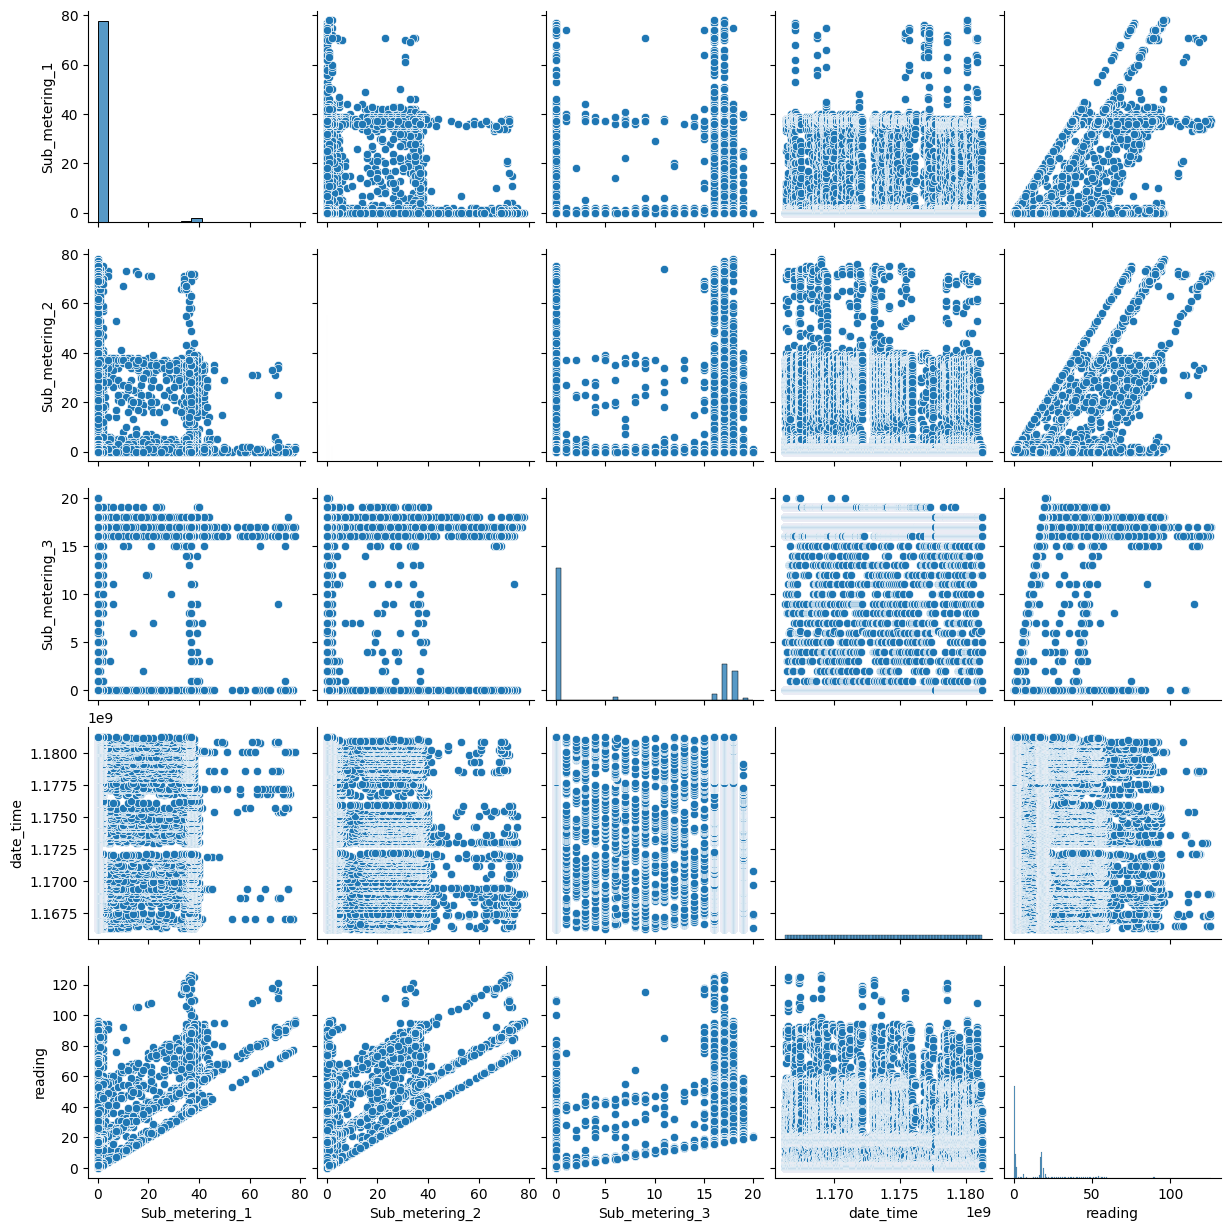

In [17]:
sb.pairplot(df)

In [18]:
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i : i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)
arr = np.arange(15)
sequence_length = 50 # Adjust as needed
x, y = create_sequences(arr, sequence_length)

In [19]:
x,y = create_sequences(df['reading'],sequence_length)

In [20]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Pratham Bisht\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.fit(x, y, epochs=5, batch_size=64)

Epoch 1/5
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - loss: 152.1360
Epoch 2/5
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - loss: 151.0477
Epoch 3/5
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - loss: 149.7891
Epoch 4/5
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - loss: 145.6379
Epoch 5/5
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - loss: 324.1817


In [24]:
pred = model.predict(x)

7811/7811 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


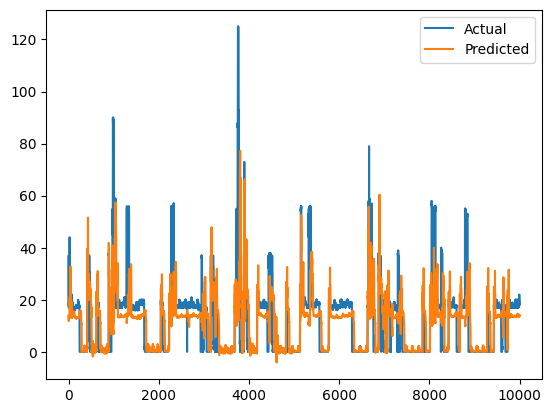

In [25]:
plt.plot(y[:10000], label='Actual')
plt.plot(pred[:10000], label='Predicted')
plt.legend()
plt.show()